We Start our model by importing all libraries needed

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
import csv
from keras.layers import Conv2D,MaxPool2D,Flatten,LSTM,Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from keras.callbacks import ModelCheckpoint
import pickle
from keras.models import load_model 
from cfg import Config


In [16]:
file_dir = r"C:\Users\fzhaj\Desktop\Projet 5A\DCASE_2023_Challenge_Task_7_Dataset\clean_dev\\"

Here we check if our directory contain prepared data

In [ ]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for model')
        with open(config.p_path,'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

Let's build our random features using defined parametres in cfg.py 

In [9]:
def build_rand_feat(train=True):
    tmp = check_data()
    if(train):
        if tmp:
            return tmp.data[0],tmp.data[1]
    
    X = []
    y = []
    if(tmp):
        _min , _max = tmp.min,tmp.max
    else:
        _min , _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=probabilties)
        file = np.random.choice(df[df.label==rand_class].index)
        rate,wav = wavfile.read(file_dir+file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat,nfilt=config.nfilt,nfft=config.nfft)
        if(not tmp):
            _min = min(np.amin(X_sample),_min)
            _max = max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X,y = np.array(X),np.array(y)
    X = (X - _min)/(_max - _min)
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    y = to_categorical(y,num_classes=7)
    config.data = (X,y)
    with open(config.p_path,'wb') as handle:
        pickle.dump(config,handle,protocol=2)
    return X,y
    

This cell defines a convolutional neural network (CNN) model for audio classification. The model architecture consists of multiple convolutional layers followed by max pooling, dropout, and dense layers. The output layer uses softmax activation for multi-class classification. The model is compiled with the categorical cross-entropy loss function, Adam optimizer, and accuracy metric.

In [10]:
def conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(7,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [12]:
df = pd.read_csv('data_labeled.csv')
df.set_index('fname',inplace =True)

In [17]:
for f in df.index:
    rate,signal = wavfile.read(file_dir+f)
    df.at[f,'length'] = signal.shape[0]/rate

In [18]:
df = df[df['length'] > 0.5]

In [19]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
class_dist

label
dog_bark                2.919940
footstep                3.460266
gunshot                 3.086763
keyboard                3.680230
moving_motor_vehicle    3.969351
rain                    3.933350
sneeze_cough            2.268705
Name: length, dtype: float64

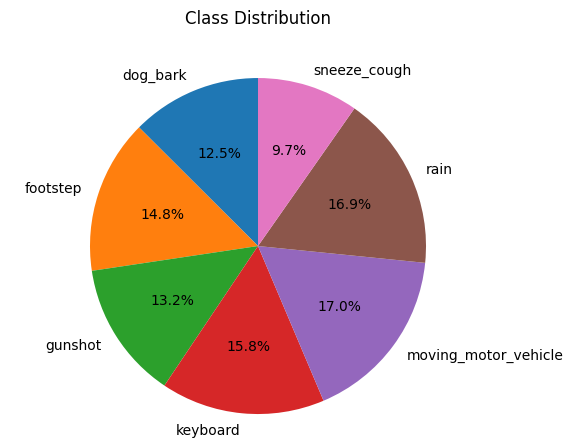

In [20]:
fig,ax = plt.subplots()
ax.set_title('Class Distribution',y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()

In [21]:
n_samples = 2*int(df['length'].sum()/0.5)
probabilties = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index,p=probabilties)
n_samples,probabilties,choices

(63798,
 label
 dog_bark                0.125219
 footstep                0.148391
 gunshot                 0.132373
 keyboard                0.157824
 moving_motor_vehicle    0.170222
 rain                    0.168679
 sneeze_cough            0.097292
 Name: length, dtype: float64,
 'sneeze_cough')

In [22]:
config = Config()

In [23]:
X,y = build_rand_feat()


100%|██████████| 63798/63798 [02:44<00:00, 388.82it/s]


In [25]:
eval_dir = r"C:\Users\fzhaj\Desktop\Projet 5A\DCASE_2023_Challenge_Task_7_Dataset\clean_eval\\"
df_eval = pd.read_csv('eval_labeled.csv')
df_eval.set_index('fname',inplace =True)
for f in df_eval.index:
    rate,signal = wavfile.read(file_dir+f)
    df_eval.at[f,'length'] = signal.shape[0]/rate

df_eval = df_eval[df_eval['length'] > 0.5]
classes = list(np.unique(df_eval.label))
class_dist = df_eval.groupby(['label'])['length'].mean()

n_samples = 2*int(df_eval['length'].sum()/0.5)
probabilties = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index,p=probabilties)
n_samples,probabilties,choices

(8878,
 label
 dog_bark                0.127232
 footstep                0.149834
 gunshot                 0.118056
 keyboard                0.147385
 moving_motor_vehicle    0.174341
 rain                    0.175241
 sneeze_cough            0.107911
 Name: length, dtype: float64,
 'gunshot')

In [26]:
X_eval,y_eval = build_rand_feat(False)

100%|██████████| 8878/8878 [00:24<00:00, 365.89it/s]


In [27]:
y_flat = np.argmax(y,axis=1)
input_shape = (X.shape[1],X.shape[2],1)
model = conv_model()
class_weight = compute_class_weight(class_weight = "balanced", classes = np.unique(y_flat), y = y_flat)
class_weights = dict(zip(np.unique(y_flat), class_weight))
checkpoint = ModelCheckpoint('models.model',monitor='val_acc',verbose=1,mode='max',save_best_only=True,save_weights_only=False,period=1)
model.fit(X,y,epochs=10, batch_size=32,shuffle=True,class_weight=class_weights,validation_data=(X_eval,y_eval),callbacks=[checkpoint])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 49, 13, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 13, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 49, 13, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 6, 128)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 6, 128)        0         
                                                        

INFO:tensorflow:Assets written to: models.model\assets


1994/1994 [==============================] - 286s 143ms/step - loss: 0.9886 - acc: 0.6260 - val_loss: 0.6647 - val_acc: 0.7639
Epoch 2/10
1994/1994 [==============================] - ETA: 0s - loss: 0.5901 - acc: 0.7931
Epoch 2: val_acc improved from 0.76391 to 0.79928, saving model to models.model
INFO:tensorflow:Assets written to: models.model\assets


INFO:tensorflow:Assets written to: models.model\assets


1994/1994 [==============================] - 284s 143ms/step - loss: 0.5901 - acc: 0.7931 - val_loss: 0.5583 - val_acc: 0.7993
Epoch 3/10
1994/1994 [==============================] - ETA: 0s - loss: 0.4524 - acc: 0.8431
Epoch 3: val_acc did not improve from 0.79928
1994/1994 [==============================] - 303s 152ms/step - loss: 0.4524 - acc: 0.8431 - val_loss: 0.5597 - val_acc: 0.7988
Epoch 4/10
1994/1994 [==============================] - ETA: 0s - loss: 0.3752 - acc: 0.8697
Epoch 4: val_acc improved from 0.79928 to 0.87385, saving model to models.model
INFO:tensorflow:Assets written to: models.model\assets


INFO:tensorflow:Assets written to: models.model\assets


1994/1994 [==============================] - 303s 152ms/step - loss: 0.3752 - acc: 0.8697 - val_loss: 0.3645 - val_acc: 0.8738
Epoch 5/10
1994/1994 [==============================] - ETA: 0s - loss: 0.3236 - acc: 0.8890
Epoch 5: val_acc did not improve from 0.87385
1994/1994 [==============================] - 305s 153ms/step - loss: 0.3236 - acc: 0.8890 - val_loss: 0.4048 - val_acc: 0.8664
Epoch 6/10
1994/1994 [==============================] - ETA: 0s - loss: 0.2835 - acc: 0.9023
Epoch 6: val_acc improved from 0.87385 to 0.89525, saving model to models.model
INFO:tensorflow:Assets written to: models.model\assets


INFO:tensorflow:Assets written to: models.model\assets


1994/1994 [==============================] - 305s 153ms/step - loss: 0.2835 - acc: 0.9023 - val_loss: 0.3090 - val_acc: 0.8952
Epoch 7/10
1994/1994 [==============================] - ETA: 0s - loss: 0.2478 - acc: 0.9134
Epoch 7: val_acc improved from 0.89525 to 0.90865, saving model to models.model
INFO:tensorflow:Assets written to: models.model\assets


INFO:tensorflow:Assets written to: models.model\assets


1994/1994 [==============================] - 266s 133ms/step - loss: 0.2478 - acc: 0.9134 - val_loss: 0.2667 - val_acc: 0.9087
Epoch 8/10
1994/1994 [==============================] - ETA: 0s - loss: 0.2295 - acc: 0.9213
Epoch 8: val_acc improved from 0.90865 to 0.91214, saving model to models.model
INFO:tensorflow:Assets written to: models.model\assets


INFO:tensorflow:Assets written to: models.model\assets


1994/1994 [==============================] - 245s 123ms/step - loss: 0.2295 - acc: 0.9213 - val_loss: 0.2508 - val_acc: 0.9121
Epoch 9/10
1994/1994 [==============================] - ETA: 0s - loss: 0.2045 - acc: 0.9291
Epoch 9: val_acc did not improve from 0.91214
1994/1994 [==============================] - 254s 128ms/step - loss: 0.2045 - acc: 0.9291 - val_loss: 0.2911 - val_acc: 0.9075
Epoch 10/10
1994/1994 [==============================] - ETA: 0s - loss: 0.1906 - acc: 0.9350
Epoch 10: val_acc did not improve from 0.91214
1994/1994 [==============================] - 255s 128ms/step - loss: 0.1906 - acc: 0.9350 - val_loss: 0.2711 - val_acc: 0.9114


In [70]:
model.save('model.model')

INFO:tensorflow:Assets written to: model.model\assets


INFO:tensorflow:Assets written to: model.model\assets


In [29]:
import tensorflow as tf
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open('audio_model' + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\fzhaj\AppData\Local\Temp\tmpt9hl_ic9\assets


INFO:tensorflow:Assets written to: C:\Users\fzhaj\AppData\Local\Temp\tmpt9hl_ic9\assets


2475816